## A quick overview of scikit-learn

To begin with, we will play around with a library some of you may already be familiar with - `sci-kit learn` (or `sklearn`)! Unsurprisingly they are the originators of the "scikit-learn-like API" (API = Application Programming Interface) - which revolves around treating models as "estimators" with a universal interface. 

To see this API in action - let's explore a simple goal: You are building a model of diabetes disease progression as a function of age, BMI, blood serum.

In [1]:
from sklearn.datasets import load_diabetes   # our diabetes dataset
from sklearn.model_selection import train_test_split   # will allow us to helpfully subdivide our data
from sklearn.linear_model import LinearRegression  # a simple model we can play around with

# load, then split our data - by loading X and y we get a frame of all our patient attributes (age, sex serum etc) and a seperate frame of outcomes
attributes, progression = load_diabetes(return_X_y=True, as_frame=True)
attributes_train, attributes_test, progression_train, progression_test = train_test_split(attributes, progression, test_size=0.33)

# create an instance of our model:
linear_regression = LinearRegression()

# fit this instance of the model to our training data:
linear_regression.fit(attributes_train, progression_train)

# use our model to predict disease progression for our reserved test- set of points.
progression_predict = linear_regression.predict(attributes_test)

As you can see working with the model follows a simple formula:
- Instantiate an instance of our model of interest
- Fit the model to the data
- Use the fitted model to predict on new data points

Because all models or estimators in the `sklearn` library follow this same design interface (and by extension all regressors do!) we could have easily selected a different model for our goal, and interfacing with it would have looked much the same.  One thing to note that can look different is that different estimators sometimes take special parameters.  Those are always set in the model instantiation step! 

In [3]:
# two new popular regressors:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# instantiate
gradient_boosted = GradientBoostingRegressor(loss="quantile")
random_forest = RandomForestRegressor(max_depth = 10)

# fit
gradient_boosted.fit(attributes_train, progression_train)
random_forest.fit(attributes_train, progression_train)

# predict
gradient_progression_predict = gradient_boosted.predict(attributes_test)
forest_progression_predict = random_forest.predict(attributes_test)

Designing libraries with components like this has many advantages:
- For one - if you learn how to use with one model, you should be able to easily use another! Once you are familiar with how the library works, its easy to use all of it!
- The seperate components we see above are also modular - making it easy for one to replace them for one another. 
- Once you have modular components - you can begin to string them together into more complex data analysis workstreams.

## What is sktime?

So far we have only talked about `sklearn` but if you were paying attention to the title of this tutorial it is actually about `sktime`!

`sktime` was inspired by the way that `sklearn` designed their data-science library, and wanted to extend that way of designing + thinking about problems to problems surrounding time-series.

At the time `sktime` was created there were a lot of different libraries for dealing with time-series data (which often included a handful of useful algorithms for time-series analysis), but no unified interface that would allow you to tackle wide classes of problems in time series (classification, forecasting, annotation) with a variety of different models. Or to quickly assemble complex workflows for time series analysis in a `scikit-learn`-like manner. 

![](../images/sktime_vs_other_packages.png)

We have designed our models to follow the design principles you see in scikit-learn.  To start with lets take a quick look at a problem - forecasting the number of passengers we have on an airline.  Lets take a quick look at what that data might look like:

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

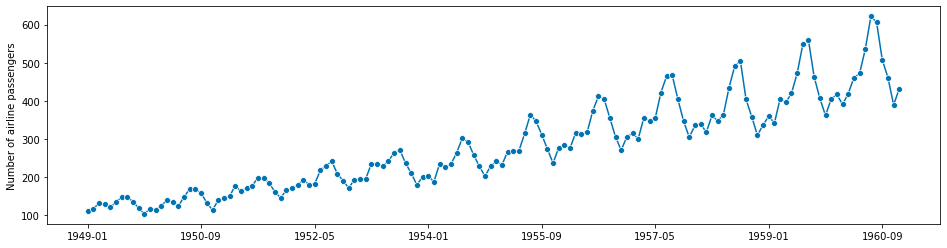

In [4]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
plot_series(y)

We can now use one of the estimators in `sktime` to try and answer out problem. Note that as with `sklearn` estimators, many of our estimators can take special variables at instantiation time.  

In [5]:
from sktime.forecasting.naive import NaiveForecaster

# Instantiate our model
forecaster = NaiveForecaster(strategy="last")

# Fit the model
forecaster.fit(y)

NaiveForecaster()

Now we can check out the prediction of the model.  To do this you need ot first be familiar with the concept of a forecasting horizon - basically we need to give our model time stamps of the points in the future you would like forecasts for.  This can be done very simply with a numpy array, or with a `ForecastingHorizon` object, a class of object within `sktime` we created for this purpose.  Here is what both of those methods would look like:

In [7]:
# simple numpy array:
import numpy as np
numpy_fh = np.arange(1, 37)

# using sktime ForecastingHorizon object:
from sktime.forecasting.base import ForecastingHorizon
import pandas as pd
sktime_fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)

# lets check out how they look:
print(f'numpy forecasting horizon: {numpy_fh}')
print(f'sktime forecasting horizon: {sktime_fh}')

numpy forecasting horizon [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
sktime forecasting horizon ForecastingHorizon(['1961-01', '1961-02', '1961-03', '1961-04', '1961-05', '1961-06',
             '1961-07', '1961-08', '1961-09', '1961-10', '1961-11', '1961-12',
             '1962-01', '1962-02', '1962-03', '1962-04', '1962-05', '1962-06',
             '1962-07', '1962-08', '1962-09', '1962-10', '1962-11', '1962-12',
             '1963-01', '1963-02', '1963-03', '1963-04', '1963-05', '1963-06',
             '1963-07', '1963-08', '1963-09', '1963-10', '1963-11', '1963-12'],
            dtype='period[M]', is_relative=False)


Both methods are acceptible.  In some cases the `sktime` version can be handy because it has some built in functionality (for example you can convert back and forth from relative and absolute time stamps) but sometimes the simple numpy array is all you need.  We just wanted to make you aware of both. Now that we are familiar with it, lets return to our original goal of looking at the performance of our `NaiveForecaster`:

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

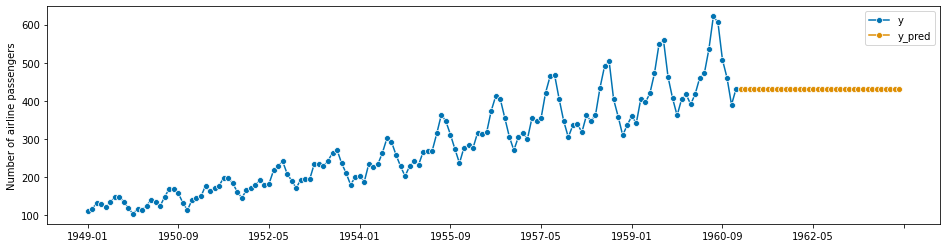

In [8]:
fh = np.arange(1, 37)
y_pred = forecaster.predict(fh)
# plotting predictions and past data
plot_series(y, y_pred, labels=["y", "y_pred"])

Wow, not so great. But perhaps not surprising, as all our `NaiveForecaster` is doing is guessing the last point it saw over and over again! But perhaps there is a way this can still be improved. Remember the possibility to input different parameters upon instantiation.  Lets try a version of the model with a set of parameters that might make more sense.  In particular there is a `sp` parameter for the NaiveForecasting model, that defines a space it should look back in time for it's current value.  Looking at our data, we might note that there is a yearly pattern in the number of passengers, so perhaps the historical data from a year in the past may be a good place to start:

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

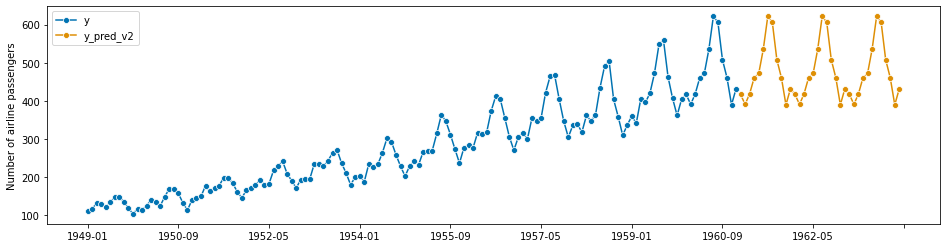

In [9]:
# Instantiate our model - not with new parameter!
forecaster_v2 = NaiveForecaster(strategy="last", sp=12)

# Fit the model
forecaster_v2.fit(y)

y_pred_v2 = forecaster_v2.predict(fh)
# plotting predictions and past data
plot_series(y, y_pred_v2, labels=["y", "y_pred_v2"])

Better!  Perhaps still not a reliable forecast in the long run, but already looking more realistic than our first pass. As you can see with the design of these models modifying our parameters didn't change how we interacting with the model at all - making it easy for us to potentially explore a variety of models and parameters until we find on that makes more sense for our data analysis goals!